## The purpose of the dev version: to add source plane
## 1. From forward modeling
## 2. From delens

In [ ]:
# can I do: output = !pip install ipympl?
# !pip install ipympl

In [ ]:
# this shows ipympl is not in the JaxEnv backend
# !conda list ipympl

In [ ]:
#!nvidia-smi

In [ ]:
from platform import python_version
print(python_version())

In [3]:
%matplotlib inline
# %matplotlib ipympl
from os.path import expanduser
home = expanduser("~")

import sys
sys.path.insert(0, home+'/gigalens-xh-dev/src')
sys.path.insert(0, home+'/anaconda3')


from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import sis, epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import matplotlib as mpl

from lenstronomy.Plots import lens_plot
from lenstronomy.LensModel.lens_model import LensModel

import optax
from objax.functional import average_pool_2d

tfd = tfp.distributions

import matplotlib.patches as patches
from matplotlib.path import Path

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interpolate

from ipdb import set_trace

# checking if using dev
import inspect
# import gigalens
import os

# print(gigalens.__file__)
print(inspect.getfile(os))
print(inspect.getfile(ModellingSequence))
print(inspect.getfile(PhysicalModel))

jax.device_count()

/Users/xiaoshenghuang/miniforge3/lib/python3.9/os.py
/Users/xiaoshenghuang/gigalens-xh-dev/src/gigalens/jax/inference.py
/Users/xiaoshenghuang/gigalens-xh-dev/src/gigalens/model.py


1

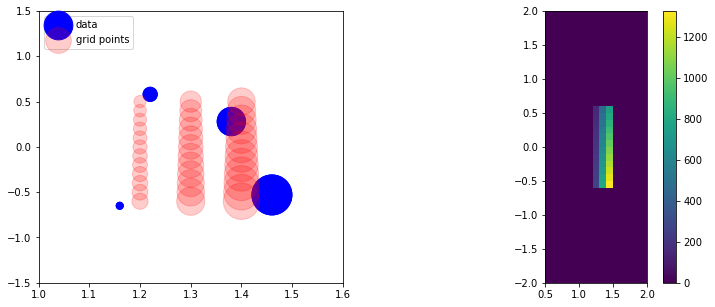

In [4]:
'''
Interpolation example: interpolate grid points onto "data"

Note: origin='lower' for imshow
'''

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

u = np.array([1.22, 1.38, 1.46, 1.16])
v = np.array([0.58, 0.28, -0.53, -0.65])
uvpix = np.array([200, 800, 1600, 50])
ax1.scatter(u, v, s=uvpix, c='b', label='data')

h = interpolate.interp2d(u, v, uvpix, fill_value=0.0)

ulo, uhi = 0.5, 2
vlo, vhi = -2, 2
u1 = np.arange(ulo, uhi, 0.1)
v1 = np.arange(vlo, vhi, 0.1)

extent = [ulo, uhi, vlo, vhi]

uu, vv = np.meshgrid(u1, v1)

ax1.scatter(u, v, s=uvpix, c='b')
ax1.set_xlim(1.0, 1.6)
ax1.set_ylim(-1.5, 1.5)
newpix1 = h(u1, v1)

u1.shape, v1.shape, newpix1.shape
ax1.scatter(uu.flatten(), vv.flatten(), s=newpix1.flatten(), c='r', alpha=0.2, label='grid points')
ax1.legend(loc='upper left')

im = ax2.imshow(newpix1, origin='lower', extent=extent)
fig.colorbar(im)

In [218]:
# How to average pool
# One has to be very careful with shape!!!
a = jnp.array(np.random.random((1, 1, 16, 16)))
b = average_pool_2d(a, size=(2, 2)) 
c = average_pool_2d(a, size=2)
a.shape, b.shape, c.shape

((1, 1, 16, 16), (1, 1, 8, 8), (1, 1, 8, 8))

In [5]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)


# more readable form 
def extract_params(best_params):

    # mass_params = ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']
    # shear_params = ['gamma1', 'gamma2']
    mass_params = ['theta_E', 'center_x', 'center_y']

    # if not using linear inversion -- then Ie is included
    light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y', 'Ie']
    # if using linear inversion -- then no Ie
    # light_params = ['R_sersic', 'n_sersic', 'e1', 'e2','center_x', 'center_y']

    count = 0
    for i in range(len(best_params)):
        if i==0:
            print('Lens mass params ({:d} sets):'.format(len(best_params[i])))
        elif i==1:
            print('Lens light params({:d} sets):'.format(len(best_params[i])))
        elif i==2:
            print('Source light params({:d} sets):'.format(len(best_params[i])))
        for j in range(len(best_params[i])):
            if j > 0:
                print()
            for k in range(len(best_params[i][j])):
                if i==0:
                    if j==0:
                        print('{:5s}={:6.3f}  '.format(mass_params[k], best_params[i][j][mass_params[k]]), end='')
                    elif j==1:
                        print('{:5s}={:6.3f}  '.format(shear_params[k], best_params[i][j][shear_params[k]]), end='')

                else:
                    print('{:5s}={:6.3f}  '.format(light_params[k], best_params[i][j][light_params[k]]), end='')

                count += 1
        print('\n')


center: 30
theta_E_pix: 16.923076923076923
src center in pix (x, y): 34.61538461538461 30.0
beta for lens #0
lens SIS
lens params {'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'theta_E': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>}


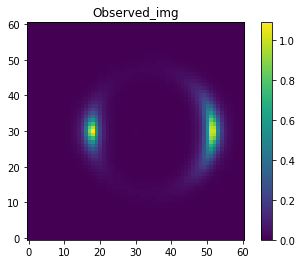

Ie, observed_img.max, observed_img.min 100 1.090741 -5.200406e-06
theta_E location in pixels: 46.0
edge, corner in arcsec: 2.015 2.849640328181787


In [857]:
delta_pix = 0.065
num_pix = 61
ctr = num_pix//2
supersample = 1
theta_E = 1.1 #* (num_pix/101)
Ie_src = 100

print('center:', ctr)

kernel = np.load('./src/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
# phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
phys_model = PhysicalModel([sis.SIS()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])

lens_sim = LensSimulator(phys_model, sim_config, bs=1)

# background_rms, exp_time = 0.2, 100
background_rms, exp_time = 2e-6, 1e6

# clearly problematic case: theta_E = 1.1, delta_pix = 0.065, num_pix = 61

theta_E_pix = theta_E / delta_pix
print('theta_E_pix:', theta_E_pix)

lens_ctrx, lens_ctry = 0.0, 0.

src_ctrx, src_ctry = 0.3, 0.0  #0.5, 0.
src_ctrx_pix, src_ctry_pix = ctr + src_ctrx / delta_pix, ctr + src_ctry / delta_pix  #0.5, 0.
print('src center in pix (x, y):', src_ctrx_pix, src_ctry_pix)


# # Now I make up other systems

# truth = [[
#     {'theta_E': theta_E, 'gamma': 2.0, 'e1': 0.2, 'e2': 1e-6, 'center_x': 0.0, 'center_y': 0.0},
#     {'gamma1': 1e-6, 'gamma2': 1e-6}
# ], [
#     {'R_sersic': 0.8, 'n_sersic': 4.0, 'e1': 1e-6, 'e2': 1e-6, 'center_x': 1e-6, 'center_y': 2e-6, 'Ie': 100.}
# ], [
#     {'R_sersic': 0.1, 'n_sersic': 1.0, 'e1': 0., 'e2': 0., 'center_x': 0.0, 'center_y': 0.5, 'Ie': 500.}
# ]]


lens_params = [{'theta_E': theta_E, 'center_x': lens_ctrx, 'center_y': lens_ctry}]
source_light = [{'R_sersic': 0.1, 'n_sersic': 1.0, 'e1': 0., 'e2': 0., 'center_x': src_ctrx, 'center_y': src_ctry, 'Ie': Ie_src}]

truth = [lens_params, 
        [{'R_sersic': 0.8, 'n_sersic': 4.0, 'e1': 1e-6, 'e2': 1e-6, 'center_x': 1e-6, 'center_y': 2e-6, 'Ie': 1e-3}], 
        source_light]

noiseless_img = lens_sim.simulate(truth)
observed_img = noiseless_img + \
                np.random.normal(0, background_rms, noiseless_img.shape) + \
                np.random.poisson(noiseless_img/exp_time, noiseless_img.shape)

# observed_img = np.load('./src/gigalens/assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

# plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

# I also don't know how Ie translates to pixel values
plt.imshow(observed_img, origin='lower') #, vmin=0, vmax=10)
plt.colorbar()
plt.title('Observed_img')
plt.show()

print('Ie, observed_img.max, observed_img.min', Ie_src, observed_img.max(), observed_img.min())
print('theta_E location in pixels:', theta_E//delta_pix + ctr)
print('edge, corner in arcsec:', (num_pix-ctr)*delta_pix, (num_pix-ctr)*delta_pix*np.sqrt(2))

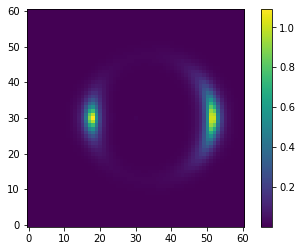

In [858]:
plt.imshow(noiseless_img, origin='lower')
plt.colorbar()

shapes of beta_x, beta_y: (61, 61, 1) (61, 61, 1)
(1, 1, 61, 61) (1, 1, 61, 61)
down sampled alpha shapes: (1, 1, 61, 61) (1, 1, 61, 61)
(61, 61)
(3721,)
(1, 1, 61, 61) (61, 61)


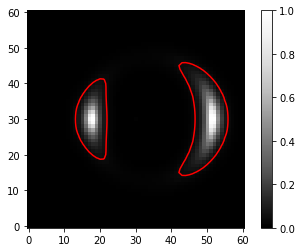

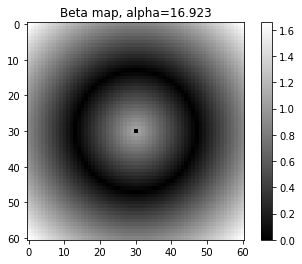

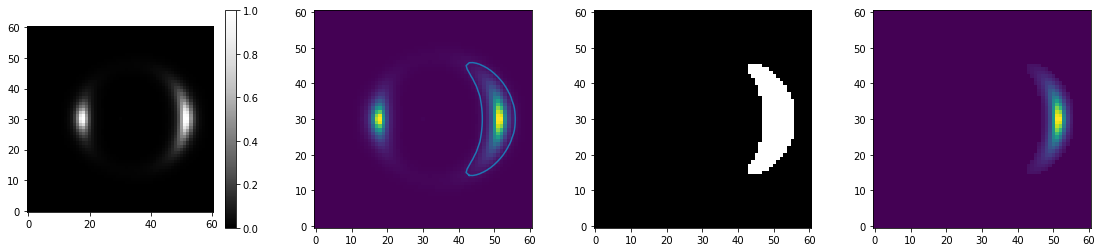

In [860]:
con_levels = [0.04] #[0.001]

fig, ax = plt.subplots(1, 1)
obsim = ax.imshow(observed_img, cmap=plt.cm.Greys_r, origin='lower', vmin=0, vmax=1)
fig.colorbar(obsim, ax=ax)

X, Y = np.meshgrid(np.linspace(0, num_pix - 1, num_pix), np.linspace(0, num_pix - 1, num_pix))
cs = plt.contour(X, Y, observed_img, con_levels, colors='r')

num_axes = len(cs.collections[0].get_paths())

# fig, axes = plt.subplots(1, num_axes, figsize=(16, 2))
# for i, path in enumerate(cs.collections[0].get_paths()):
#     verts = path.vertices
#     xc, yc = verts[:, 0], verts[:, 1]
#     axes[i].plot(xc, yc)

#-------------------------------------------------------------------------------------------------------------------------
lens_params = truth[0]

beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of beta_x, beta_y:', beta_x.shape, beta_y.shape)
fig, ax = plt.subplots(1, 1)
beta = np.sqrt(beta_x ** 2 + beta_y ** 2)
betaim = plt.imshow(beta, interpolation=None, cmap='gray')
fig.colorbar(betaim, ax=ax)
plt.title('Beta map, alpha={:.3f}'.format(theta_E_pix))

## One has to be very careful with shape!!!
from objax.functional import average_pool_2d
f_xi = jnp.transpose(f_xi, (2, 0, 1))[jnp.newaxis, ...] 
f_yi = jnp.transpose(f_yi, (2, 0, 1))[jnp.newaxis, ...] 

print(f_xi.shape, f_yi.shape) #, f_yi_newaxis.shape)

f_xi_downsamp = average_pool_2d(f_xi, size=lens_sim.supersample, padding="SAME") 
f_yi_downsamp = average_pool_2d(f_yi, size=lens_sim.supersample, padding="SAME") 

print('down sampled alpha shapes:', f_xi_downsamp.shape, f_yi_downsamp.shape)

# ----------------------------------------------------------------------------------------------------------------
n_subfigs = 4
axes = []*n_subfigs
fig_h = 4

# To get the BIG arc
fig, axes = plt.subplots(1, n_subfigs, figsize=(fig_h*n_subfigs*1.2, fig_h))
axes[0].set_aspect('equal')

obsim = axes[0].imshow(observed_img, cmap=plt.cm.Greys_r, origin='lower', vmin=0, vmax=1)
plt.colorbar(obsim, ax=axes[0])

idx_cont = [0, 1]
verts = np.array([[], []]).T

for i, idx in enumerate(idx_cont):
    if i == 0: #or i == 4: 
        # break
        verts = np.concatenate((verts, cs.collections[0].get_paths()[idx].vertices), axis=0)

xc, yc = verts[:, 0], verts[:, 1]
axes[1].plot(xc, yc)

obsim = axes[1].imshow(observed_img, origin='lower', vmin=0, vmax=1)

print(X.shape)
path = Path(verts)
points = np.vstack((X.flatten(), Y.flatten())).T

counterarcmask = path.contains_points(points)
print(counterarcmask.shape)

counterarcmask = counterarcmask.reshape((num_pix, num_pix))

axes[2].imshow(counterarcmask, cmap='gray', origin='lower')

counterarc = observed_img * counterarcmask
axes[3].imshow(counterarc, origin='lower')

print(f_xi_downsamp.shape, counterarcmask.shape)

f_xi_ca = f_xi_downsamp * counterarcmask
f_yi_ca = f_yi_downsamp * counterarcmask


shapes of beta_x, beta_y, f_xi, f_yi: (61, 61, 1) (61, 61, 1) (61, 61, 1) (61, 61, 1)
(61, 61, 1) (61, 61, 1)
down sampled alpha shapes: (1, 1, 61, 61) (1, 1, 61, 61)
beta shapes: (61, 61, 1) (61, 61, 1)
(61, 61, 1)
max img: 2.7577164


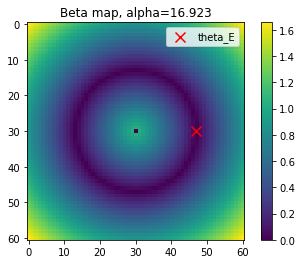

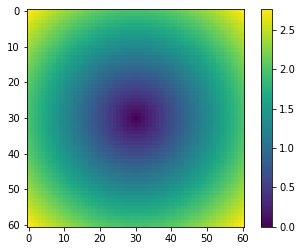

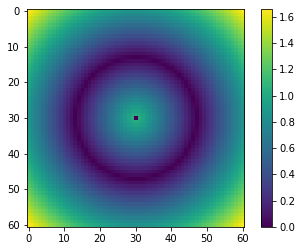

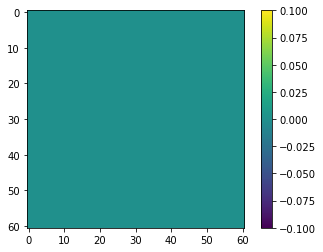

In [861]:
lens_params = truth[0]

beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of beta_x, beta_y, f_xi, f_yi:', beta_x.shape, beta_y.shape, f_xi.shape, f_yi.shape)
fig, ax = plt.subplots(1, 1)
beta = np.sqrt(beta_x ** 2 + beta_y ** 2)
betaim = ax.imshow(beta)
ax.scatter(ctr+theta_E_pix, ctr, marker='x', color='r', s=100, label='theta_E')
ax.legend()
fig.colorbar(betaim, ax=ax)
plt.title('Beta map, alpha={:.3f}'.format(theta_E_pix))

## w/ jnp average_pool_2d, one has to be very careful with shape!!!
print(f_xi.shape, f_yi.shape) #, f_yi_newaxis.shape)

f_xi_downsamp = average_pool_2d(jnp.transpose(f_xi, (2, 0, 1))[jnp.newaxis, ...], size=lens_sim.supersample, padding="SAME") 
f_yi_downsamp = average_pool_2d(jnp.transpose(f_yi, (2, 0, 1))[jnp.newaxis, ...], size=lens_sim.supersample, padding="SAME") 

print('down sampled alpha shapes:', f_xi_downsamp.shape, f_yi_downsamp.shape)
print('beta shapes:', beta_x.shape, beta_y.shape)

fig, ax = plt.subplots(1, 1)

imgX = lens_sim.img_X
imgY = lens_sim.img_Y
print(imgX.shape)
# img_X_t1 = imgX[..., 0]
# img_Y_t1 = imgY[..., 0]

# img_t1 = np.sqrt(img_X_t1**2 + img_Y_t1**2)
img = np.sqrt(imgX ** 2 + imgY ** 2)
print('max img:', img.max())


im = ax.imshow(img)
fig.colorbar(im, ax=ax)

b_x, b_y = imgX - f_xi, imgY - f_yi
b = np.sqrt(b_x**2 + b_y**2)
fig, ax = plt.subplots(1, 1)
bim = ax.imshow(b)
fig.colorbar(bim, ax=ax)

fig, ax = plt.subplots(1,1)
bres = ax.imshow(b - beta)
fig.colorbar(bres, ax=ax)

30.0 (3721, 2)


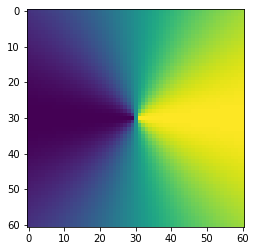

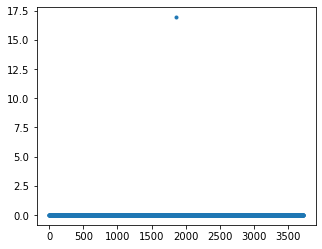

[-41.966423 -42.167496 -42.371704 -42.578823 -42.788586 -43.000668
 -43.214706 -43.430264 -43.646854 -43.863926] [43.863926 43.646854 43.430264 43.214706 43.000668 42.788586 42.578823
 42.371704 42.167496 41.966423]
[-41.966423 -40.761913 -39.546925 -38.320942 -37.083443 -35.833893
 -34.571762 -33.296535 -32.007694 -30.704748] [30.704748 32.007694 33.296535 34.571762 35.833893 37.083443 38.320942
 39.546925 40.761913 41.966423]


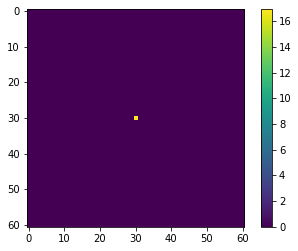

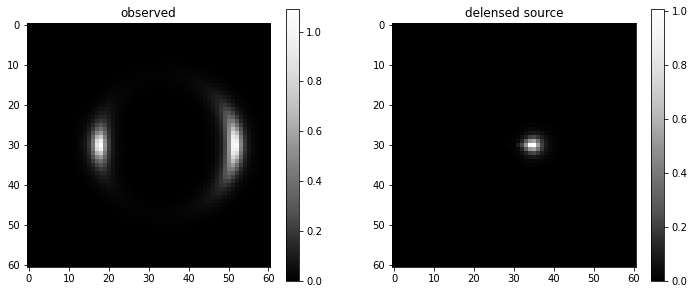

{'R_sersic': 0.1, 'n_sersic': 1.0, 'e1': 0.0, 'e2': 0.0, 'center_x': 0.3, 'center_y': 0.0, 'Ie': 100}
-4.063613e-06 1.2725622e-19


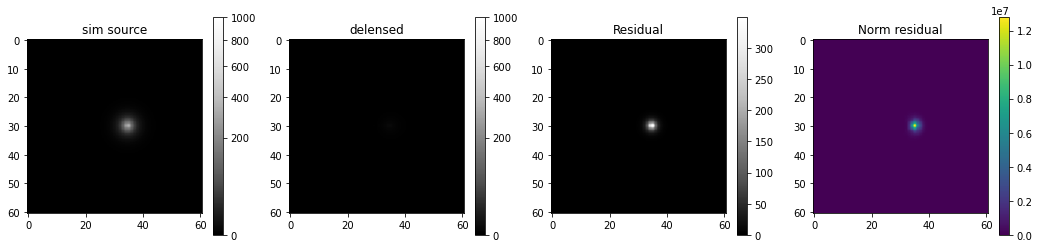

In [862]:
'''
Breakout Solution: Fisheye distortion

One can shift the "center" to have different parts of the face be at 
the center of the final image.

One can obviously shift the different parameters in the r 
equation to enhance or reduce the effect.


'''

from skimage import transform, data, io
import matplotlib.image as mpimg
import matplotlib.cm as cm

import numpy as np
import matplotlib.pyplot as plt


home = os.path.expanduser('~')
path = home + '/USF-Teaching-repos/PHYS301/CompPhys-I/code/ipy_notebboks/images/'


'''
After dinner, 9/24/22
1. add lens model in specification
2. Compute my own f_xi, f_yi
3. Compute my own beta_x and beta_y
3. do the lens and delense operation successively -- they *have to* give me the same answer

Not sure why I need two [0][0] -- b/c of the comma in the lens_prior?

'''
imgX = lens_sim.img_X
imgY = lens_sim.img_Y
f_xi, f_yi = phys_model.lenses[0].deriv(imgX, imgY, **lens_params[0])

f = np.sqrt(f_xi ** 2 + f_yi ** 2)

f_xi_flat = np.squeeze(f_xi).flatten()/ delta_pix
f_yi_flat = np.squeeze(f_yi).flatten()/ delta_pix

alfx_pix = np.squeeze(f_xi) / delta_pix
alfy_pix = np.squeeze(f_yi) / delta_pix

arcxy = np.where(counterarcmask > 0)

arcx = arcxy[1]
arcy = arcxy[0]

srcy = arcy - alfy_pix[arcxy]
srcx = arcx - alfx_pix[arcxy]

plt.imshow(f_xi_flat.reshape(num_pix, -1))


# astro = mpimg.imread(path + 'astronaut.png')
# astr = astro[:, :, 0]


def fisheye(xy):
#     center = np.mean(xy, axis=0)
    center = np.sqrt(xy.shape[0])/2
    xc, yc = (xy - center).T

    # Polar coordinates
    r = np.sqrt(xc**2 + yc**2)
    theta = np.arctan2(yc, xc)
    # This works, but not very intuitive
    # an alternative (using Taylor expansion of the exponential function)
    # note scale = 1, (a0, a1, a2, a3, a4,...) = (0, 1, 0, 0, 0,...)
    # corresponds to no transformation
    # Now try scale = 1, (a0, a1, a2, a3, a4, ...) = (0, 1, 0.01, 0.001, 0, ...)
    # Then you can set scale = 0.02 to get a decent FOV
    scale = .005  # or try 0.005
    a0 = 0
    a1 = 1
    a2 = 1  # 0.01
    a3 = 0  #0.001
#     r = scale * 0.8 * np.exp(r**(1/2.1) / 1.8)
    
    r = scale*(a0 + a1*r + a2*r**2 + a3*r**3)
    
    return np.column_stack((r * np.cos(theta), r * np.sin(theta))) + center


def delensing(xy):
    center = np.sqrt(xy.shape[0])//2
    print(center, xy.shape)
    xc, yc = (xy - center).T

    r = np.sqrt(xc**2 + yc**2)
    theta = np.arctan2(yc, xc)
    
    alf_xx, alf_yy = theta_E_pix*np.cos(theta), theta_E_pix*np.sin(theta)

    # xnew = xc + alf_x
    # ynew = yc + alf_y
    
    # ---------> note how the x and y need to swapped to get this right
    
    xnew = xc + f_yi_flat
    ynew = yc + f_xi_flat
    
    plt.figure(figsize=(5, 4))
    plt.plot(alf_xx - f_yi_flat, '.')
    plt.show()
    
    plt.figure()
    plt.imshow(alf_xx.reshape(num_pix, -1) - f_yi_flat.reshape(num_pix, -1))
    plt.colorbar()
    
    print(xnew[:10], xnew[-10:])
    print(ynew[:10], ynew[-10:])

    return np.column_stack((xnew, ynew)) + center


# out = transform.warp(astr, fisheye)
# f, (ax0, ax1) = plt.subplots(1, 2, subplot_kw=dict(xticks=[], yticks=[]))
# ax0.imshow(astr, cmap=cm.Greys_r)
# ax1.imshow(out, cmap=cm.Greys_r)

observed_im = np.squeeze(observed_img)

delens = transform.warp(observed_im, delensing)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5)) # subplot_kw=dict(xticks=[], yticks=[]))
obsim = ax0.imshow(observed_im, cmap=cm.Greys_r)
ax0.set_title('observed')
f.colorbar(obsim, ax=ax0)
delensim = ax1.imshow(delens, cmap=cm.Greys_r)
ax1.set_title('delensed source')
f.colorbar(delensim, ax=ax1)
plt.show()


# delens = delens + srcim.min()

print(source_light[0])

srcimg = phys_model.source_light[0].light(imgX, imgY, **source_light[0])
srcim = np.squeeze(srcimg)

print(delens.min(), srcim.min())

f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(18, 4)) # subplot_kw=dict(xticks=[], yticks=[]))

lensedim = ax0.imshow(srcim, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=1000), cmap=cm.Greys_r)
f.colorbar(lensedim, ax = ax0)
ax0.set_title('sim source')

delensedim = ax1.imshow(delens, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=1000), cmap=cm.Greys_r)
f.colorbar(delensedim, ax = ax1)
ax1.set_title('delensed')

res = np.array(srcim - delens)
normres = res/np.array(observed_im)
resim = ax2.imshow(res, cmap=cm.Greys_r)
f.colorbar(resim, ax=ax2)
ax2.set_title('Residual')

normresim = ax3.imshow(normres) #, vmin=0, vmax=1.0)
f.colorbar(normresim, ax=ax3)
ax3.set_title('Norm residual')

plt.show()


16.923079 16.923079


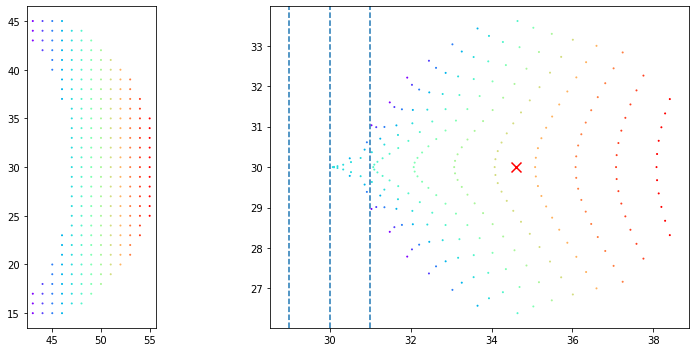

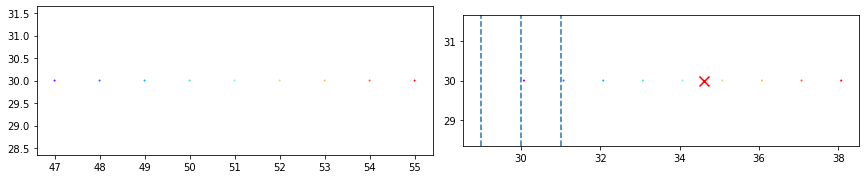

In [863]:
'''
Now delens:
'''
alfx_pix = np.squeeze(f_xi_downsamp) / delta_pix
alfy_pix = np.squeeze(f_yi_downsamp) / delta_pix

arcxy = np.where(counterarcmask > 0)

arcx = arcxy[1]
arcy = arcxy[0]

srcy = arcy - alfy_pix[arcxy]
srcx = arcx - alfx_pix[arcxy]

hiy = np.percentile(arcy, 90)
idx = arcy >= hiy

arcx_hiy = arcx[idx]
arcy_hiy = arcy[idx]

srcx_hiy = srcy[idx]
srcy_hiy = srcy[idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(arcx, arcy, c=arcx, cmap='rainbow', s=1)

ax1.set_aspect('equal')

nub_ln1 = ctr
nub_ln2 = ctr - 1.
nub_ln3 = ctr + 1.


ax2.scatter(srcx, srcy, c=arcx, cmap='rainbow', s=1)
ax2.axvline(nub_ln1, ls='--')
ax2.axvline(nub_ln2, ls='--')
ax2.axvline(nub_ln3, ls='--')


# ax2.plot(srcx, srcy, '.', ms=1)
# ax2.plot(srcx_hiy, srcy_hiy, 'r.')

ax2.set_aspect('equal')
ax2.scatter(src_ctrx/delta_pix + ctr, src_ctry/delta_pix + ctr, s=100, marker='x', color='r')
plt.tight_layout()
print(alfx_pix.max(), alfy_pix.max())

# zoom on the flat part

arc_loc = ctr + theta_E_pix
arc_w = 40
arc_h = 40

# idx1 = (arcx > arc_loc - arc_w/1) * (arcy > ctr - arc_h/0.6) * (arcy < ctr + arc_h/0.6)
# idx2 =  (arcy > ctr + arc_h/4) + (arcy < ctr - arc_h/4)
# idx3 =  (arcy < ctr + arc_h/8) * (arcy > ctr - arc_h/8)

idx4 = arcy == ctr

# idx = idx1 * idx2
idx = idx4

flat_arcx = arcx[idx]
flat_arcy = arcy[idx]

flat_srcx = srcx[idx]
flat_srcy = srcy[idx]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(flat_arcx, flat_arcy, c=flat_arcx, cmap='rainbow', s=1)
# ax1.plot(arcx, arcy, '.')
# ax1.plot(arcx_hiy, arcy_hiy, 'r.')

ax1.set_aspect('equal')

ax2.scatter(flat_srcx, flat_srcy, c=flat_arcx, cmap='rainbow', s=1)

ax2.set_aspect('equal')
ax2.scatter(src_ctrx/delta_pix + ctr, src_ctry/delta_pix + ctr, s=100, marker='x', color='r')
ax2.axvline(nub_ln1, ls='--')
ax2.axvline(nub_ln2, ls='--')
ax2.axvline(nub_ln3, ls='--')


plt.tight_layout()


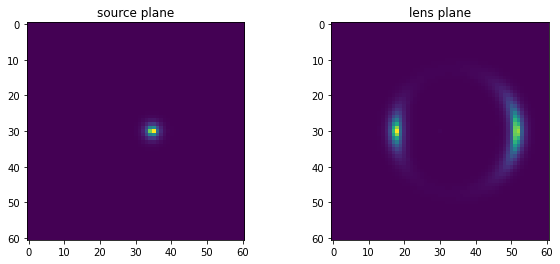

In [864]:
# create an the unlensed source light
# for lightModel, p in zip(self.phys_model.lens_light, lens_light_params):
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
# phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
xphys_model = PhysicalModel([[sis.SIS()]], [], [sersic.SersicEllipse(use_lstsq=False)])

src_sim = LensSimulator(xphys_model, sim_config, bs=1)

# type(src_sim)
source_light = [{'R_sersic': 0.1, 'n_sersic': 1.0, 'e1': 0., 'e2': 0., 'center_x': src_ctrx, 'center_y': src_ctry, 'Ie': Ie_src}]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

srcimg = xphys_model.source_light[0].light(imgX, imgY, **source_light[0])
ax1.imshow(srcimg)
ax1.set_title('source plane')

lensed_srcimg = xphys_model.source_light[0].light(beta_x, beta_y, **source_light[0])
ax2.imshow(lensed_srcimg)
ax2.set_title('lens plane')


lensed = np.squeeze(lensed_srcimg)

# delensed_srcimg = lensed_srcimg - 


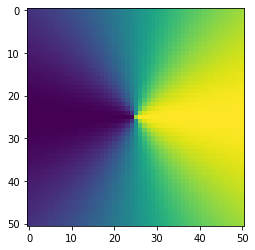

In [809]:
'''
After dinner, 9/24/22
1. add lens model in specification
2. Compute my own f_xi, f_yi
3. Compute my own beta_x and beta_y
3. do the lens and delense operation successively -- they *have to* give me the same answer

Not sure why I need two [0][0] -- b/c of the comma in the lens_prior?

'''
imgX = src_sim.img_X
imgY = src_sim.img_Y
f_xi, f_yi = xphys_model.lenses[0][0].deriv(imgX, imgY, **lens_params[0])

f = np.sqrt(f_xi ** 2 + f_yi ** 2)

f_xi_flat = np.squeeze(f_xi).flatten()/ delta_pix
f_yi_flat = np.squeeze(f_yi).flatten()/ delta_pix


alfx_pix = np.squeeze(f_xi) / delta_pix
alfy_pix = np.squeeze(f_yi) / delta_pix

arcxy = np.where(counterarcmask > 0)

arcx = arcxy[1]
arcy = arcxy[0]

srcy = arcy - alfy_pix[arcxy]
srcx = arcx - alfx_pix[arcxy]

plt.imshow(f_xi_flat.reshape(num_pix, -1))

25.0 (2601, 2)
[-34.899498 -35.099422 -35.303032 -35.509987 -35.719868 -35.932163
 -36.14627  -36.36148  -36.57697  -36.791798] [36.791798 36.57697  36.36148  36.14627  35.932163 35.719868 35.509987
 35.303032 35.099422 34.899498]
[-34.899498 -33.695446 -32.47879  -31.24879  -30.004688 -28.745731
 -27.471165 -26.180265 -24.87234  -23.546751] [23.546751 24.87234  26.180265 27.471165 28.745731 30.004688 31.24879
 32.47879  33.695446 34.899498]


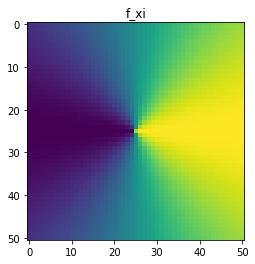

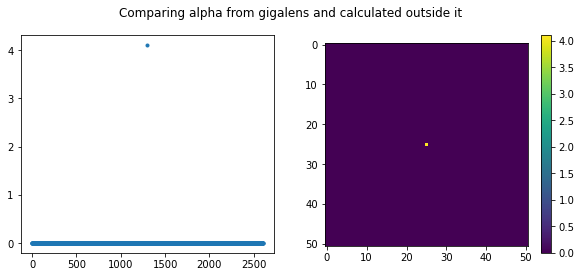

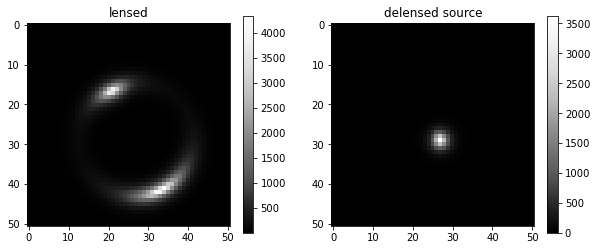

min of delens and srcim: 0.0 2.1842977e-11


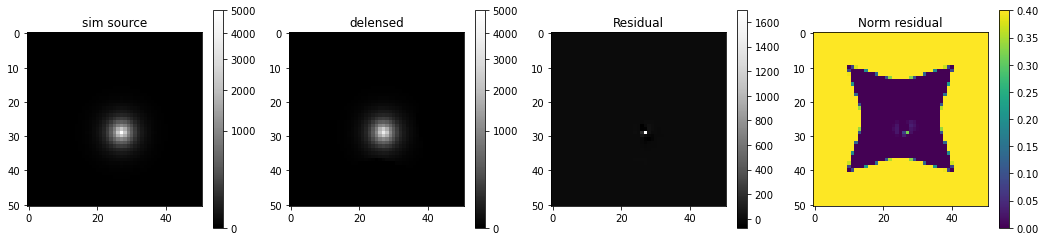

In [818]:
'''
1. add lens model in specification
2. Compute my own f_xi, f_yi
3. Compute my own beta_x and beta_y
3. do the lens and delense operation successively -- they *have to* give me the same answer

Not sure why I need two [0][0] -- b/c of the comma in the lens_prior?

'''

from skimage import transform, data, io
import matplotlib.image as mpimg
import matplotlib.cm as cm

home = os.path.expanduser('~')
path = home + '/USF-Teaching-repos/PHYS301/CompPhys-I/code/ipy_notebboks/images/'

imgX = src_sim.img_X
imgY = src_sim.img_Y
f_xi, f_yi = xphys_model.lenses[0][0].deriv(imgX, imgY, **lens_params[0])

f = np.sqrt(f_xi ** 2 + f_yi ** 2)

f_xi_flat = np.squeeze(f_xi).flatten()/ delta_pix
f_yi_flat = np.squeeze(f_yi).flatten()/ delta_pix


alfx_pix = np.squeeze(f_xi) / delta_pix
alfy_pix = np.squeeze(f_yi) / delta_pix

arcxy = np.where(counterarcmask > 0)

arcx = arcxy[1]
arcy = arcxy[0]

srcy = arcy - alfy_pix[arcxy]
srcx = arcx - alfx_pix[arcxy]

plt.imshow(f_xi_flat.reshape(num_pix, -1))
plt.title('f_xi')

def delensing(xy):
    center = np.sqrt(xy.shape[0])//2
    print(center, xy.shape)
    xc, yc = (xy - center).T

    r = np.sqrt(xc**2 + yc**2)
    theta = np.arctan2(yc, xc)
    
    alf_xx, alf_yy = theta_E_pix*np.cos(theta), theta_E_pix*np.sin(theta)
    # xnew = xc + alf_xx
    # ynew = yc + alf_yy
    
    # ---------> note how the x and y need to swapped to get this right
    xnew = xc + f_yi_flat
    ynew = yc + f_xi_flat
    
    f, (ax1, ax2)= plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(alf_xx - f_yi_flat, '.')
    alf_res = ax2.imshow(alf_xx.reshape(num_pix, -1) - f_yi_flat.reshape(num_pix, -1))
    f.colorbar(alf_res, ax=ax2)
    f.suptitle('Comparing alpha from gigalens and calculated outside it')
    
    print(xnew[:10], xnew[-10:])
    print(ynew[:10], ynew[-10:])

    return np.column_stack((xnew, ynew)) + center

delens = transform.warp(lensed, delensing)
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4)) # subplot_kw=dict(xticks=[], yticks=[]))
lensedim = ax0.imshow(lensed, cmap=cm.Greys_r)
f.colorbar(lensedim, ax=ax0)
ax0.set_title('lensed')

delensim = ax1.imshow(delens, cmap=cm.Greys_r)
f.colorbar(delensim, ax=ax1)
ax1.set_title('delensed source')

plt.show()

srcim = np.squeeze(srcimg)

print('min of delens and srcim:', delens.min(), srcim.min())

f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(18, 4)) # subplot_kw=dict(xticks=[], yticks=[]))

lensedim = ax0.imshow(srcim, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=5000), cmap=cm.Greys_r)
f.colorbar(lensedim, ax = ax0)
ax0.set_title('sim source')

delensedim = ax1.imshow(delens, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=5000), cmap=cm.Greys_r)
f.colorbar(delensedim, ax = ax1)
ax1.set_title('delensed')

res = np.array(srcim - delens)
normres = res/np.array(srcim)
resim = ax2.imshow(res, cmap=cm.Greys_r)
f.colorbar(resim, ax=ax2)
ax2.set_title('Residual')

normresim = ax3.imshow(normres, vmin=0, vmax=0.4)
f.colorbar(normresim, ax=ax3)
ax3.set_title('Norm residual')

plt.show()


In [688]:
idx = (normres==1.0)

print(srcim[idx].max(), srcim[idx].min())
res[idx].shape, srcim[idx], delens[idx]

35.288437 0.0010742355


(430,)

(array([6.000e+00, 4.000e+00, 1.600e+01, 2.531e+03, 3.000e+01, 5.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([-26.216003 , -19.036356 , -11.856708 ,  -4.67706  ,   2.5025878,
          9.682236 ,  16.861883 ,  24.04153  ,  31.22118  ,  38.400826 ,
         45.580475 ,  52.760124 ,  59.93977  ,  67.119415 ,  74.299065 ,
         81.478714 ,  88.65836  ,  95.83801  , 103.017654 , 110.1973   ,
        117.37695  ], dtype=float32),
 <BarContainer object of 20 artists>)

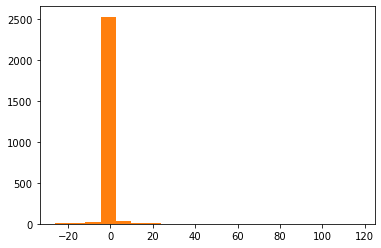

In [678]:
normres.shape, res.shape, type(normres), type(res)
plt.hist(normres.flatten(), bins=20)
plt.hist(res.flatten(), bins=20)

5323.333 1.8458192e-11 0.0 5323.334
117.37695 -26.216003 0.11187378 3.9074442 2.945233e-06
1.0 -0.08525494 0.71541667 0.4564028 1.0
(51, 51) (51, 51) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


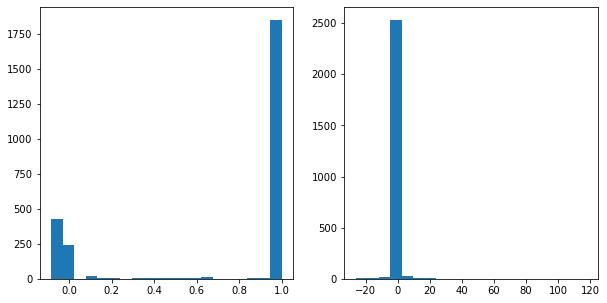

In [680]:
'''
skimage.transform produces a delensed image with background pixels set to zero. 

So need to reset the minimum to get the normalized residual right.

I should use one or several simulated systems as a test for this way of delensing
'''

print(srcim.max(), srcim.min(), delens.min(), delens.max())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(normres.flatten(), bins=20)
ax2.hist(res.flatten(), bins=20)

plt.show()

(-0.0001, 0.001)

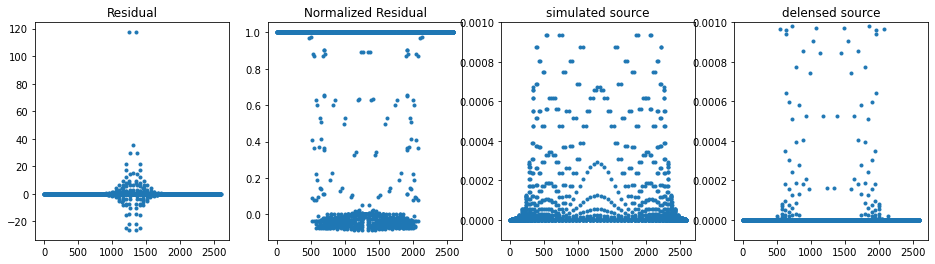

In [702]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
res = srcim - delens
normres = res / srcim
ax1.plot(res.flatten(), '.')
ax1.set_title('Residual')
ax2.plot(normres.flatten(), '.')
ax2.set_title('Normalized Residual')
ax3.plot(srcim.flatten(), '.')
ax3.set_title('simulated source')
ax3.set_ylim(-1e-4, 1e-3)

ax4.plot(delens.flatten(), '.')
ax4.set_title('delensed source')
ax4.set_ylim(-1e-4, 1e-3)

In [635]:
x, y = np.arange(num_pix), np.arange(num_pix)
xx, yy = np.meshgrid(x, y)

xy = np.column_stack((xx.flatten(), yy.flatten()))
center = np.sqrt(xy.shape[0])//2
xc, yc = (xy - center).T

print(center, xy.shape)

r = np.sqrt(xc**2 + yc**2)
theta = np.arctan2(yc, xc)

alf_xx, alf_yy = theta_E_pix*np.cos(theta), theta_E_pix*np.sin(theta)
print(alf_xx.shape, alf_yy.shape)

xnew = xc + alf_xx
ynew = yc + alf_yy
    
print(xnew[:10], xnew[-10:])
print(ynew[:10], ynew[-10:])


25.0 (2601, 2)
(2601,) (2601,)
[-34.89949494 -33.69544559 -32.47879143 -31.24879053 -30.00468921
 -28.74573067 -27.47116575 -26.18026616 -24.8723403  -23.54675175] [23.54675175 24.8723403  26.18026616 27.47116575 28.74573067 30.00468921
 31.24879053 32.47879143 33.69544559 34.89949494]
[-34.89949494 -35.09942249 -35.30303416 -35.50998924 -35.71986811
 -35.93216333 -36.14627072 -36.36148078 -36.57697103 -36.79179961] [36.79179961 36.57697103 36.36148078 36.14627072 35.93216333 35.71986811
 35.50998924 35.30303416 35.09942249 34.89949494]


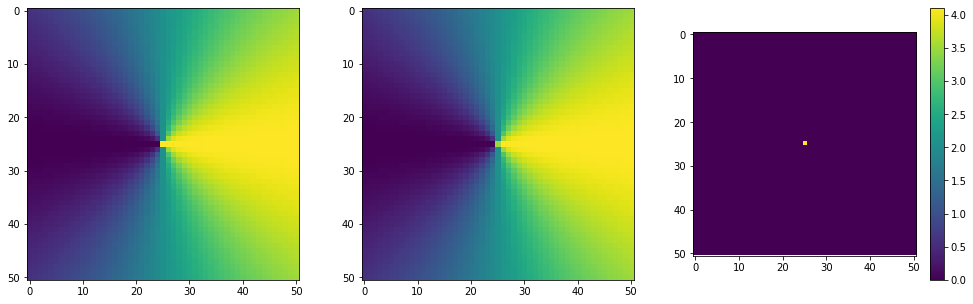

In [631]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))
ax1.imshow(alf_xx.reshape(num_pix, -1))
ax2.imshow(f_xi_flat.reshape(num_pix, -1))
resalf = ax3.imshow(alf_xx.reshape(num_pix, -1) - f_xi_flat.reshape(num_pix, -1))
fig.colorbar(resalf, ax=ax3)
# plt.colorbar()

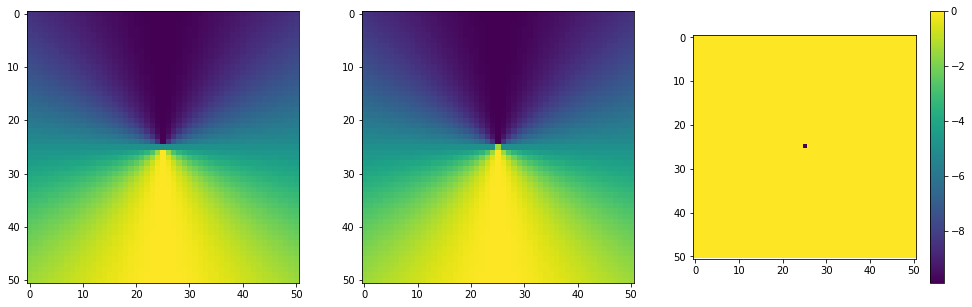

In [632]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))
ax1.imshow(alf_yy.reshape(num_pix, -1))
ax2.imshow(f_yi_flat.reshape(num_pix, -1))
resalf = ax3.imshow(alf_yy.reshape(num_pix, -1) - f_yi_flat.reshape(num_pix, -1))
fig.colorbar(resalf, ax=ax3)

(117.37695, -26.216003, 0.11187378, 3.9074442, 2.945233e-06)

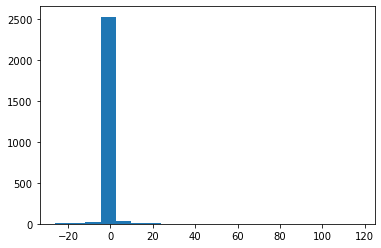

In [648]:
plt.hist(np.array(res).flatten(), bins=20)

res.max(), res.min(), res.mean(), res.std(), np.median(res)

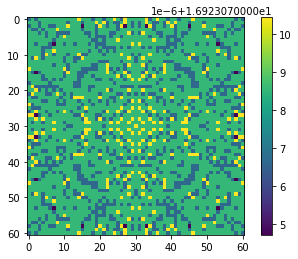

In [351]:
alf[ctr, ctr] = alf.max()
# alf_not_min = alf[1-idx_min]
plt.imshow(alf)
plt.colorbar()


In [79]:
srcx = np.array(srcx)
srcy = np.array(srcy)
srcpix = np.array(observed_img[arcxy])
print(type(srcx), type(srcy), type(srcpix))
print(srcx.shape, srcy.shape, srcpix.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(797,) (797,) (797,)


beta for lens #0
lens SIS
lens params {'center_x': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'center_y': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>, 'theta_E': Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=0/2)>}


(10.0, 110.0)

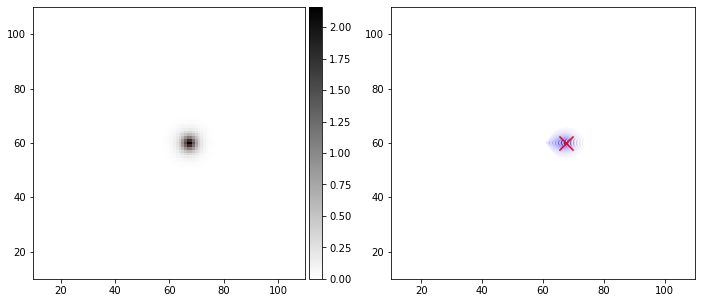

In [80]:
alphas = srcpix/10

wid = 50
xlo, xhi, ylo, yhi = ctr-wid, ctr+wid, ctr-wid, ctr+wid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
src_img = lens_sim.simulate([[{'theta_E': 1e-8, 'center_x': 1e-10, 'center_y': 1e-10}], [], source_light])
im = ax1.imshow(src_img, cmap='gray_r', interpolation='none')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax1.scatter(srcx, srcy, s=5, alpha=(alphas/30), color='r')
ax1.set_xlim(xlo, xhi)
ax1.set_ylim(ylo, yhi)


ax2.scatter(srcx, srcy, s=1, alpha=alphas, color='b')
ax2.scatter(src_ctrx/delta_pix + ctr, src_ctry/delta_pix + ctr, s=200, marker='x', color='r')
ax2.set_xlim(xlo, xhi)
ax2.set_ylim(ylo, yhi)

In [81]:
src_ctrx/delta_pix

7.5

In [82]:
print(srcx.shape, srcy.shape, srcpix.shape)
print(src_img.max(), src_img.min(), src_img.mean(), src_img.dtype)
print(srcpix.max(), srcpix.min(), srcpix.mean(), srcpix.dtype)

(797,) (797,) (797,)
2.1601377 4.2303652e-26 0.0040808697 float32
2.5716317 0.100067765 0.47916242 float32


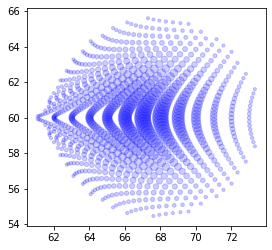

In [91]:
# size prop to to flux
plt.scatter(srcx, srcy, c='b', s=np.int64(srcpix*100), alpha=0.2); ax = plt.gca(); ax.set_aspect('equal')

In [89]:
'''
Looks to me that scipy kind of sets a rectangular box as bounds -- not the smarest thing to do

also: look into the warning message

'''

# ********************* for 480 pixels, this line takes 5 min to run
g = interpolate.interp2d(srcx, srcy, srcpix, fill_value=0.0, kind='quintic')



/Users/xiaoshenghuang/miniforge3/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=5,5 nx,ny=30,27 m=797 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


xlo, xhi 40 80
srcxlo, srcxhi 50 90


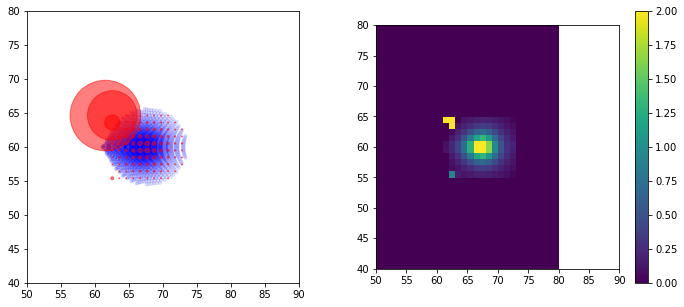

In [90]:
wid = 20

num_grid = wid * 2

xlo, xhi = ctr - wid, ctr + wid
ylo, yhi = ctr - wid, ctr + wid
xsrc = np.linspace(xlo, xhi, num_grid)
ysrc = np.linspace(ylo, yhi, num_grid)

xxsrc, yysrc = np.meshgrid(xsrc, ysrc)

src_intp = g(xsrc, ysrc)

shift = 10

srcxlo, srcxhi = ctr + shift - wid, ctr + shift + wid
srcylo, srcyhi = ctr - wid, ctr + wid

print('xlo, xhi', xlo, xhi)
print('srcxlo, srcxhi', srcxlo, srcxhi)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(srcx, srcy, c='b', s=np.int64(srcpix*100), alpha=0.1)
ax1.scatter(xxsrc.flatten(), yysrc.flatten(), s=np.int64(src_intp.flatten()*10), c='r', alpha=0.5)
# plt.xlim(32, 39)
# plt.ylim(28, 31)
ax1.set_aspect('equal')
ax1.set_xlim(srcxlo, srcxhi)
ax1.set_ylim(srcylo, srcyhi)


extent = [xlo, xhi, ylo, yhi]
im = ax2.imshow(src_intp, extent=extent, origin='lower', vmin=0, vmax=2) #, cmap='gray')
ax2.set_xlim(srcxlo, srcxhi)
ax2.set_ylim(srcylo, srcyhi)
fig.colorbar(im)

# im = ax2.imshow(src_intp.T, origin='lower', extent=extent, vmin=0, vmax=2) #, cmap='gray')
# ax2.set_xlim(srcxlo, srcxhi)
# ax2.set_ylim(srcylo, srcyhi)
# fig.colorbar(im)

In [ ]:
plt.plot(arange(10))

In [ ]:
print(src_intp.max(), src_intp.min(), src_intp.mean())
print(srcpix.max(), srcpix.min(), srcpix.mean())
src_intp_rescl = src_intp * srcpix.max() / src_intp.max()

print(src_intp_rescl.max(), src_intp_rescl.min(), src_intp_rescl.mean())
idx = src_intp_rescl > 0
print(idx.sum())

In [ ]:
plt.imshow(src_intp.T, vmin=0, vmax=3, origin='lower') #, cmap='gray')
plt.colorbar()

In [ ]:
srcx.shape, arcxy[0].shape, observed_img[arcxy].shape

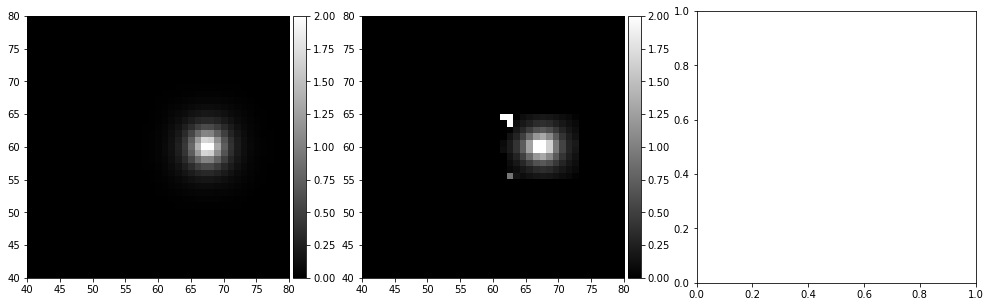

In [101]:
# comparing the true source
from mpl_toolkits.axes_grid1 import make_axes_locatable

alphas = srcpix/8

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))
src_img = lens_sim.simulate([[{'theta_E': 1e-8, 'center_x': 1e-10, 'center_y': 1e-10}], [], source_light])
im1 = ax1.imshow(src_img, vmin=0, vmax=2., cmap='gray')
ax1.axis(extent)
# ax1.scatter(srcy, srcx, s=5, alpha=alphas, color='r')
# im1 = ax1.scatter(yysrc.flatten(), xxsrc.flatten(), s=np.int64(src.flatten()*5), c='r', alpha=0.5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')



im2 = ax2.imshow(src_intp, origin='lower', extent=extent, vmin=0, vmax=2, cmap='gray') #, cmap='gray')
# ax2.set_xlim(srcxlo, srcxhi)
# ax2.set_ylim(srcylo, srcyhi)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# res = (src_img - src_intp)/src_img
# resim = ax3.imshow(resid, vmin=-1, vmax=1, cmap='gray')
# ax3.set_xlim(srcxlo, srcxhi)
# ax3.set_ylim(srcylo, srcyhi)
# divider = make_axes_locatable(ax3)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(resim, cax=cax, orientation='vertical')

# fig.colorbar(resim)



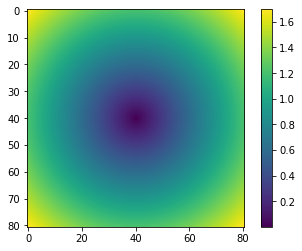

In [484]:
# I really don't understand why img_X and img_Y have structure
# I think the reason is so that they are measured from the center outside, linearly
# then they seem to be right

imgX = lens_sim.img_X
imgY = lens_sim.img_Y

img_X_t1 = imgX[..., 0]
img_Y_t1 = imgY[..., 0]


img_t1 = np.sqrt(img_X_t1**2 + img_Y_t1**2)
plt.imshow(img_t1)
plt.colorbar()

In [ ]:
plt.plot(img_t1[30, :])
pix = np.linspace(30, 60, 30)
plt.plot(pix, (pix-30)*delta_pix, '.')

In [ ]:
lens_params = truth[0]

beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of beta_x, beta_y:', beta_x.shape, beta_y.shape)

beta_x_t1, beta_y_t1 = beta_x, beta_y

beta_t1 = np.sqrt(beta_x_t1**2 + beta_y_t1**2)
plt.imshow(beta_t1)
plt.colorbar()

In [ ]:
plt.plot(beta_t1[30, :])

In [ ]:
f_xi_t1, f_yi_t1 = f_xi, f_yi
f_t1 = np.sqrt(f_xi_t1**2 + f_yi_t1**2)

plt.imshow(f_t1)
plt.colorbar()

In [ ]:
f_t1.mean(), f_t1.max(), f_t1.min()

In [ ]:
imgX.shape, type(imgX)

In [ ]:
# size = 20
# xctr, yctr = size/2, size/2
# x = np.arange(size)
# y = np.arange(size)
# xx, yy = np.meshgrid(x, y)
# alph = 2.5

xx = np.squeeze(imgX)/delta_pix
yy = np.squeeze(imgY)/delta_pix
xctr, yctr = 30, 30


r_E = theta_E/delta_pix
print(xx.shape, type(xx))

def xderiv(x, y, theta_E, center_x, center_y):
    '''Have to define it outside gigalens, b/c otherwise:
    
    ----> 1 bx, bx, alfx, alfy = sis.SIS.deriv(imgX, imgY, **lens_params)
    TypeError: gigalens.jax.profiles.mass.sis.SIS.deriv() argument after ** must be a mapping, not list
    
    '''
    _params = ["theta_E", "center_x", "center_y"]
    dx, dy = x - center_x, y - center_y
    R = np.sqrt(dx ** 2 + dy ** 2)
    a = np.where(R == 0, 0.0, theta_E / R)
    return a*R, a * dx, a * dy

print(r_E, xctr, yctr)
alf, alfx, alfy = xderiv(xx, yy, r_E, xctr, yctr)

alf_recalc = np.sqrt(alfx**2 + alfy**2)
plt.imshow(alf_recalc)
plt.colorbar()

plt.figure()
plt.imshow(alf)
plt.colorbar()

In [ ]:
alf

In [ ]:
r = np.sqrt(xx**2 + yy**2)
plt.imshow(r)
plt.colorbar()

In [ ]:
print(**lens_params[0])

In [ ]:
u = lens_params[0]
u

In [ ]:
plt.plot(f_t1[30, :])

In [ ]:
'''
Here I get

shapes of img_X, img_Y: (120, 120, 1) (120, 120, 1)
shapes of f_xi, f_yi: (120, 120, 1) (120, 120, 1)

'''

from objax.functional import average_pool_2d

# best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))


# params = best_params  
params = truth
print(len(params[0][0]))
lens_params = params[0]


imgX = lens_sim.img_X
imgY = lens_sim.img_Y

print('shapes of imgX, imgY:', imgX.shape, imgY.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


img_X_t1 = imgX[..., 0]
img_Y_t1 = imgY[..., 0]


ax1.imshow(img_X_t1)
ax1.set_title('img_X[..., 0]')
ax2.imshow(img_Y_t1)
ax2.set_title('img_Y[..., 0]')


if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]

# shape of beta_x is (116, 116, 56): 116 is b/c of supersampling by 2
# but I don't understand the 56.  In the end we only use the 0th in that dimension
beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of f_xi, f_yi:', f_xi.shape, f_yi.shape)

beta_x_t1, beta_y_t1 = beta_x, beta_y

f_xi_t1, f_yi_t1 = f_xi, f_yi

In [ ]:
img_t1 = np.sqrt(img_X_t1**2 + img_Y_t1**2)
plt.imshow(img_t1)
plt.colorbar()

In [ ]:
beta_t1 = np.sqrt(beta_x_t1**2 + beta_y_t1**2)
plt.imshow(beta_t1)
plt.colorbar()

In [ ]:
    @functools.partial(jit, static_argnums=(0,))
    def _beta(self, lens_params: List[Dict]):
        beta_x, beta_y = self.img_X, self.img_Y
        lens_i = 0
        for lens, p in zip(self.phys_model.lenses, lens_params):
            print('beta for lens #{:d}'.format(lens_i))
            print('lens', lens)
            print('lens params', p)
            lens_i += 1
            f_xi, f_yi = lens.deriv(self.img_X, self.img_Y, **p)
            beta_x, beta_y = beta_x - f_xi, beta_y - f_yi
        return beta_x, beta_y, f_xi, f_yi 


# Next: delens using f_xi_t1, f_yi_t1 and see I recover the forward model source

In [ ]:
# ********************************
# on M1, 100 samples, 200 steps: 5 min to run -- so be careful
# ********************************

map_samples = 100

map_steps = 200
transition_steps = 200

seed, lr_start, lr_end, pwr = 0, -1e-2, -1e-2/3, 0.5

schedule_fn = optax.polynomial_schedule(init_value=lr_start, end_value=lr_end, 
                                      power=pwr, transition_steps=transition_steps)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
map_estimate, chi2_hist = model_seq.MAP(opt, seed=0, n_samples=map_samples, num_steps=map_steps)
# map_estimate = model_seq.MAP(opt, seed=0, n_samples=30, num_steps=num_steps)

In [ ]:
import pickle
with open('map_est_2022_09_14-18:12_sim.pickle', 'rb') as f:
    # map_estimate = pickle.load(f)
    map_estimate, chi2_hist, hyper_params = pickle.load(f)
map_estimate.shape

In [ ]:
chi2_arr = np.array(chi2_hist)
chi2_min = chi2_arr.min()
map_samples = map_estimate.shape[0]
# map_steps, transition_steps, seed = hyper_params

map_steps, transition_steps, seed, lr_start, lr_end, pwr = hyper_params

# lr_start, lr_end, pwr = -1e-2, -1e-2/4, 0.5

plt.figure(figsize=(5, 4))
plt.plot(chi2_hist)
plt.yscale('log')
plt.text(map_steps*0.5, chi2_min*1.4, 'chi2_min:{:.3f}'.format(chi2_min))
hyper_p = 'map_samples:{:d} \n\
map_steps:{:d}  \n \
transition_steps:{:d} \n'.format(map_samples, map_steps, transition_steps) #, seed, lr_start, lr_end, pwr) 
# hyper_p = 'map_samples:{:d} \n'.format(map_samples) #, map_steps, transition_steps, seed, lr_start, lr_end, pwr) 

plt.text(map_steps*0.5, chi2_min, hyper_p)
# plt.ylim(2.5, 6)
plt.ylim(0.9, 20)
plt.show()


In [ ]:

lens_sim = LensSimulator(phys_model, sim_config, bs=len(map_estimate))
# these two lines can take long to run on cpu
# 
lps, chi2 = prob_model.log_prob(lens_sim, map_estimate)
# recon = lens_sim.lstsq_simulate(prob_model.bij.forward(list(map_estimate.T)), 
#                                 obs_data, prob_model.err_map)[np.nanargmax(lps)]

best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))

print(map_estimate.shape)
print(np.nanargmax(lps))
print(map_estimate[np.nanargmax(lps)].shape)


In [ ]:
print(lps.shape)

idx_map_best = np.argmin(chi2)
print('best idx for map:', idx_map_best)

print(chi2.min())

chi2[idx_map_best]

In [ ]:
'''
The gist of this cell is that I don't understand the shape:

shapes of img_X, img_Y: (120, 120, 22) (120, 120, 22)
shapes of f_xi, f_yi: (120, 120, 22) (120, 120, 22)

When the last value is the number of parameters.

'''

from objax.functional import average_pool_2d

map_est = map_estimate[idx_map_best]

lens_sim = LensSimulator(phys_model, sim_config, bs=len(map_est))
# this line can take long to run on cpu
lps, chi2 = prob_model.log_prob(lens_sim, map_est)

print(chi2.shape)
print(chi2)
phys_params = prob_model.bij.forward(list(map_est.T))

params = phys_params
print(len(params[0][0]))
lens_params = params[0]


print('shapes of img_X, img_Y:', lens_sim.img_X.shape, lens_sim.img_Y.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(lens_sim.img_X[..., 0])
ax1.set_title('img_X[..., 0]')
ax2.imshow(lens_sim.img_Y[..., 0])
ax2.set_title('img_Y[..., 0]')


if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]

# shape of beta_x is (116, 116, 56): 116 is b/c of supersampling by 2
# but I don't understand the 56.  In the end we only use the 0th in that dimension
beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of f_xi, f_yi:', f_xi.shape, f_yi.shape)
print(phys_params[0][0])

In [ ]:
# note in the instantiation of prob_model, the observed_img is used (though I'm not sure why)
# prob_model = ForwardProbModel(prior, observed_img, background_rms=background_rms, exp_time=exp_time)
# model_seq = ModellingSequence(phys_model, prob_model, sim_config)

## Add source plane reconstruction

## Also find the light amplitude, Ie, in the case when linear inversion is used (otherwise it's one of the fitting parameters)

In [ ]:
from objax.functional import average_pool_2d

best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))


# params = best_params  
params = truth
print(len(params[0][0]))
lens_params = params[0]


print('shapes of img_X, img_Y:', lens_sim.img_X.shape, lens_sim.img_Y.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(lens_sim.img_X[..., 0])
ax1.set_title('img_X[..., 0]')
ax2.imshow(lens_sim.img_Y[..., 0])
ax2.set_title('img_Y[..., 0]')


if len(lens_sim.phys_model.lens_light) > 0:
    lens_light_params, source_light_params = params[1], params[2]

    # print('lens_light_params', lens_light_params)
    # print('source_light_params', source_light_params)

else:
    source_light_params = params[1]

# shape of beta_x is (116, 116, 56): 116 is b/c of supersampling by 2
# but I don't understand the 56.  In the end we only use the 0th in that dimension
beta_x, beta_y, f_xi, f_yi = lens_sim._beta(lens_params)

print('shapes of f_xi, f_yi:', f_xi.shape, f_yi.shape)


f_xi_t22, f_yi_t22 = f_xi, f_yi

In [ ]:
# note here, we didn't use linear inversion so the brigtness, Ie, was fit for too.
# best_params = prob_model.bij.forward(list(map_estimate[np.nanargmax(lps)]))   
        
# extract_params(best_params)
# print('Compared with truth: \n')

print('The truth parameters:')
extract_params(truth)

print('The best_params:')
extract_params(best_params)

print('The phys_params:')
extract_params(phys_params)
# chi2_ar = chi2_arr[-100:]
# print('min chi2: {:4.3f}'.format(chi2_arr.min()))

In [ ]:
# compare best-fit parameters with observed image
from astropy import modeling

plt.figure(figsize=(15, 3))
plt.subplot(141)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
# plt.colorbar()
plt.axis('off')
plt.subplot(142)
simulated = lens_sim.simulate(truth)
plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)

plt.subplot(143)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)

norm_resid = np.asarray(resid/err_map)

plt.imshow(norm_resid, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
plt.axis('off')
plt.colorbar()

plt.subplot(144)
bin_h, bins, _ = plt.hist(norm_resid.flatten(), bins=100)
x = (bins[:-1] + bins[1:])/2
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model = fitter(model, x, bin_h)

plt.plot(x, fitted_model(x))
plt.title(r'$\mu$ = {:.3f}, $\sigma$ = {:.3f}'.format(fitted_model.mean.value, fitted_model.stddev.value))

print('Chi-square:', np.mean((resid/err_map)**2))




In [ ]:
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)


In [ ]:
from copy import copy
no_lens = copy(truth)
no_lens[0][0]['theta_E'] = 1e-12
no_lens

# next use WS code to get the source plane 

# Why does the source position doesn't seem to be very close to the center of the caustic?
# Check if the source position is right? Since I'm using the truth here.

In [ ]:
lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])

# phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
# sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=supersample, kernel=kernel)
# lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
# x = lens_sim_t.simulate([truth[0], truth[2], []])
# x = lens_sim_t.simulate(truth)
# off = -(size-2)


print('source light params:', truth[2])


print(x.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

lens_plot.lens_model_plot(ax1, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )
simulated = lens_sim.simulate([[], truth[2], []])

scale_extent = 2.0
ext_arcsec = ((num_pix+1)*delta_pix)/scale_extent
print('num_pix, delta_pix, scale_extent, ext_arcsec:', num_pix, delta_pix, scale_extent, ext_arcsec)

extent = ext_arcsec, -ext_arcsec, -ext_arcsec, ext_arcsec
print('extent', extent)

ax1.plot(0, 0, 'x', ms=10, color='red')
ax1.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=1), extent=extent)

lens_plot.lens_model_plot(ax2, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )
ax2.plot(0, 0, 'x', ms=10, color='red')




# ax.imshow(simulated, vmin=0, vmax=1, extent=extent)

# # source_img = np.rot90(np.rot90(x))
# source_img = x

# ax.imshow(source_img, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)

In [ ]:
simulated.max()

In [ ]:
lensModel = LensModel(lens_model_list=['EPL', 'SHEAR'], multi_plane=False)
kwargs_lens = truth[0]

print('lens params:', truth[0])


arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
source_img = lens_sim.simulate([no_lens[0], truth[2], []])

# plt.imshow(simulated, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)



# phys_model_t = PhysicalModel([], [sersic.SersicEllipse(use_lstsq=False)], [])
# sim_config_t = SimulatorConfig(delta_pix=delta_pix, num_pix=num_pix, supersample=2, kernel=kernel)
# lens_sim_t = LensSimulator(phys_model_t, sim_config_t, bs=1)
# source_img = lens_sim_t.simulate([[], truth[2], []])
# arcs_img = lens_sim_t.simulate([truth[0], truth[1], truth[2]])

source_arcs = source_img + arcs_img

# off = -(size-2)

print('source light params:', truth[2])

# print(x.shape)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

lens_plot.lens_model_plot(ax, lensModel=lensModel, kwargs_lens=kwargs_lens, with_caustics=True, fast_caustic=True, coord_inverse=True, with_convergence=False, deltaPix=delta_pix, numPix=num_pix, )

# scale_extent = 2

# extent = (num_pix*delta_pix)/scale_extent, -(num_pix*delta_pix)/scale_extent, \
#          -(num_pix*delta_pix)/scale_extent, (num_pix*delta_pix)/scale_extent,

# # source_img = np.rot90(np.rot90(source_img))
# # extent = -(num_pix*delta_pix), (num_pix*delta_pix), -(num_pix*delta_pix), (num_pix*delta_pix)


# # ax.imshow(source_arcs, norm=mpl.colors.PowerNorm(0.5, vmin=3.0, vmax=3.5), extent=extent)
# ax.plot(truth[2][0]['center_x'], truth[2][0]['center_y'], '*', color='gray', ms=10)
# ax.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20), extent=extent) #, cmap='GnBu')
# ax.grid(axis='both')


# ax2 = ax.twinx().twiny() #here is the trick!
# ax2.imshow(arcs_img, norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20)) #, cmap='GnBu')

# # ax2.tick_params(axis='both', labelcolor='blue')
# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
# ax2.set_xticks(np.arange(0, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, 61, 1))
# ax2.set_yticklabels(np.arange(1, 61, 1))
# # ax2.grid(which='major', axis='both')
# # ax2.set_xticks(np.linspace(0, 59, 6))
plt.show()

In [ ]:
plt.figure()
im = plt.imshow(np.reshape(np.random.rand(100), newshape=(10,10)),
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_yticklabels(np.arange(1, 11, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

In [ ]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major')

# ax.imshow(arcs_img)

In [ ]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()
ax.tick_params(top=True, labeltop=True, right=True, labelright=True)

# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

ax.grid(which='major')


In [ ]:
plt.figure(figsize=(10, 10))
im = plt.imshow(arcs_img,
                interpolation='none', vmin=0, vmax=1, aspect='equal')

ax = plt.gca()
ax.tick_params(left=False, labelleft=False, \
               bottom=False, labelbottom=False, \
               top=False, labeltop=False, \
               right=False, labelright=False)


# Major ticks
ax.set_xticks(np.arange(0, 60, 1))
ax.set_yticks(np.arange(0, 60, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 61, 1))
ax.set_yticklabels(np.arange(1, 61, 1))

# ax.grid(which='major')

ax2 = ax.twiny() #here is the trick!
ax2.tick_params(left=False, labelleft=False, \
               bottom=False, labelbottom=False, \
               top=False, labeltop=False, \
               right=False, labelright=False)

# ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=False, labeltop=False, right=False, labelright=False)
# # Major ticks
# # ax2.set_xticks(np.arange(0, 60, 1))
# ax2.set_yticks(np.arange(0, 60, 1))

# # Labels for major ticks
# # ax2.set_xticklabels(np.arange(1, 61, 1))
# ax2.set_yticklabels(np.arange(1, 61, 1))
# ax2.grid(which='major', axis='x')


In [ ]:
truth[2][0]

In [ ]:
arcs_img = lens_sim.simulate([truth[0], [], truth[2]])
plt.imshow(arcs_img)

In [ ]:
source_img = lens_sim.simulate([[], truth[2], []])
plt.imshow(source_img + arcs_img)

## Next: add cautic and critical curves -- reproduce one of the four archetypes

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

nx, ny = 3, 3

np.random.seed(seed=1)
img = np.reshape(np.random.rand(nx*ny), newshape=(nx, ny))

im = ax.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')

# Major ticks
ax.set_xticks(np.arange(0, nx, 1))
ax.set_yticks(np.arange(0, ny, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, nx+1, 1))
ax.set_yticklabels(np.arange(1, ny+1, 1))

# # Minor ticks
# ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
# ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
# ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.grid(which='major', axis='both')

ax2 = ax.twiny() #here is the trick!

# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
ax2.set_xticks(np.arange(0, nx, 1))
ax2.set_yticks(np.arange(0, ny, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, nx+1, 1))
# ax2.set_yticklabels(np.arange(1, ny+1, 1))
ax2.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')


ax2.grid(which='major', axis='y')



ax3 = ax2.twiny() #here is the trick!

# ax2.tick_params(top=True, labeltop=True, right=True, labelright=True)
# # Major ticks
ax3.set_xticks(np.arange(0, nx, 1))
ax3.set_yticks(np.arange(0, ny, 1))

# # Labels for major ticks
# ax2.set_xticklabels(np.arange(1, nx+1, 1))
# ax2.set_yticklabels(np.arange(1, ny+1, 1))
ax3.imshow(img, interpolation='none', vmin=0, vmax=1, aspect='equal')


ax3.grid(which='major', axis='y')
plt.show()

